<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/YourFirstGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# input image dimensions
img_shape = (img_rows, img_cols, channels)
# Size of the noise vector 
z_dim = 100

#Generator

In [3]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  # Fully connected layer
  model.add(Dense(128, input_dim=z_dim))
  # leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))
  # Output layer with tanh activation
  model.add(Dense(28*28*1, activation='tanh'))
  # Reshape the Generator output to image dimensions
  model.add(Reshape(img_shape))

  return model

# Discrimnator

In [4]:
def build_discriminator(img_shape):
  model = Sequential()
  # Flatten the input image
  model.add(Flatten(input_shape=img_shape))
  # Fully connected layer
  model.add(LeakyReLU(alpha=0.01))
  # Output layer with sigmoid activation
  model.add(Dense(1, activation='sigmoid'))

  return model


# Build the Model

In [5]:
def build_gan(generator, discriminator):
  model = Sequential()
  # Combined Gen. and Disc.
  model.add(generator)
  model.add(discriminator)

  return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile GAN model with fixed discriminator to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIS dataset
  (X_train, _),(_,_) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train/127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size,1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    #-------------------------------
    # Train the Discriminator
    #-------------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Geneator a batch of fake images
    z = np.random.normal(0, 1, (batch_size,100))
    gen_imgs = generator.predict(z)

   # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
        (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

In [ ]:
a = []
a.append(1)
a

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5*gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

Train the GAN and Inspect Output

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.696909, acc.: 59.38%] [G loss: 0.892615]
2000 [D loss: 0.645966, acc.: 65.23%] [G loss: 1.201776]
3000 [D loss: 0.429317, acc.: 85.55%] [G loss: 1.456601]
4000 [D loss: 0.265466, acc.: 94.53%] [G loss: 2.026611]
5000 [D loss: 0.098962, acc.: 99.61%] [G loss: 2.769659]


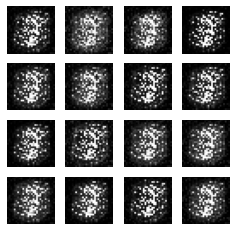

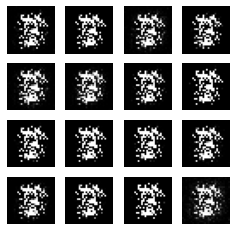

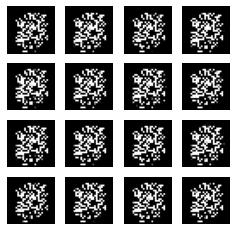

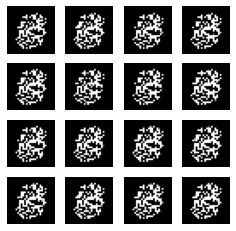

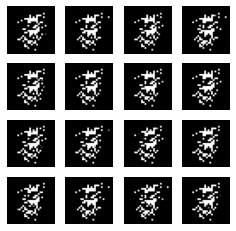

In [9]:
# Set hyperparameters
iterations = 5000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

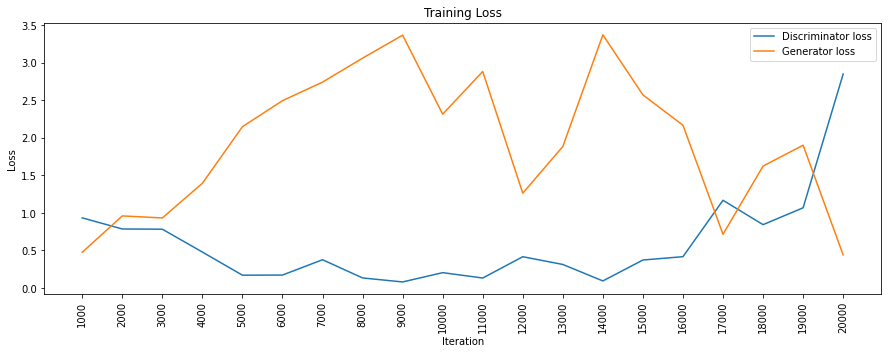

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

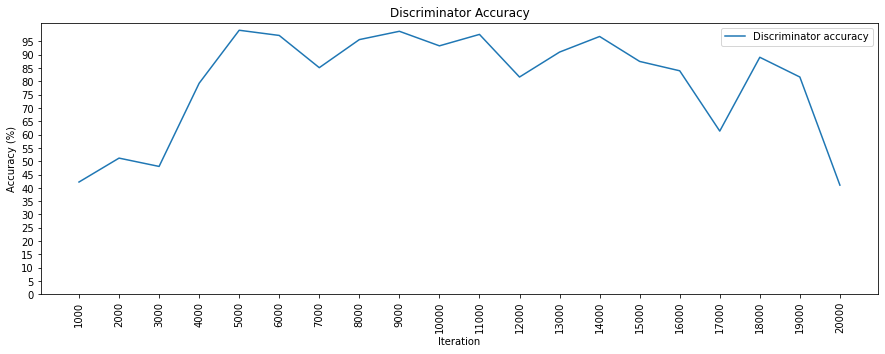

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()